# Quadrotor Ball Sim
by Sebastian Lopez-Cot

This python notebook can be used to run the quad-ball system. The quadrotor will try to send a ball to a desired location given initial conditions and will attempt to return to its original starting point.

desired_theta,  1.29388748748
desired_vlaunch,  10.2967999224
desired_launch_vec,  [ 2.81497578  9.90454441]
arch_width:  5.68421052632
apex:  5.0
travel_time:  2.01927510938
vland:  [ 2.81497578 -9.90454441]
theta:  1.29388748748
Number of decision vars:  320
Solve:  SolutionResult.kSolutionFound
Constructing time interpolator...
Done constructing time interpolator!
Constructing time interpolator...
Done constructing time interpolator!
[ 2.81497578 -9.56634359]
tang_comp [ 0.0889329  0.0252757]
norm_comp [ 2.72604288 -9.59161929]
[-2.91299991  9.95954693]
CONTACT
arch_width:  5.91423071013
apex:  5.05469089875
travel_time:  2.03028867127
vland:  [-2.91299991 -9.95856593]
theta:  -1.28622334767
Number of decision vars:  320
Solve:  SolutionResult.kSolutionFound
Constructing time interpolator...
Done constructing time interpolator!
Constructing time interpolator...
Done constructing time interpolator!
[-2.91299991 -9.62023207]
tang_comp [-0.09129813  0.02670445]
norm_comp [-2.82170178 -

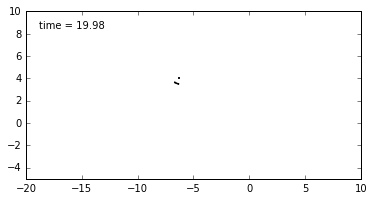

In [5]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

from sim import ProjectileMath, TimeInterpolator, ContactingSwitch, Quadrotor, Ball, Animator
from quad_direct_transcription import QuadDirectTranscription

def plan_trajectory(init_quad_state, init_ball_state, ball_goal):
    # Given the ball's state, calculate it's arch info
    quad_target = np.zeros(6)
    arch_width, apex, travel_time, vland, theta = ProjectileMath.calc_arch_info(init_ball_state)
    print "arch_width: ", arch_width
    print "apex: ", apex
    print "travel_time: ", travel_time
    print "vland: ", vland
    print "theta: ", theta
    quad_target[0] = init_ball_state[0] + arch_width * np.sign(init_ball_state[2])
    quad_target[1] = init_ball_state[1]
    quad_target[2] = np.sign(theta) * (np.pi/2.0 - abs(theta))
    
    push_vel = 5.0
    norm = np.array([-np.sin(quad_target[2]), np.cos(quad_target[2])])
    quad_target[3:5] = push_vel * norm
    
    fall_time = travel_time
    return qdt.solve(init_quad_state, quad_target, fall_time)

quad = Quadrotor()
ball = Ball()
sw = ContactingSwitch()
qdt = QuadDirectTranscription(quad.m, quad.g)

dt = 0.0001
steps = 200000
downsample = 600

time = dt * np.arange(steps)

quad_state = np.zeros((steps, 6))
quad_state[0,0] = np.random.choice(np.linspace(-5, 5, 20))
quad_state[0,1] = np.random.choice(np.linspace(0, 5, 20))
quad_state[0,2] = np.random.choice(np.linspace(-np.pi/3.0, np.pi/3.0, 20))

ball_state = np.zeros((steps, 4))
ball_state[0, 0] = np.random.choice(np.linspace(-6,-3,20))
ball_state[0, 1] = 0.0

desired_width = abs(0.0 - ball_state[0,0])
desired_apex = 5.0
desired_theta = np.arctan(4.0 * desired_apex / desired_width)
desired_vlaunch = np.sqrt(2.0*9.81*desired_apex / np.sin(desired_theta)**2.0)
desired_launch_vec = desired_vlaunch * np.array([np.cos(desired_theta), np.sin(desired_theta)])
desired_launch_vec[0] *= np.sign(0.0 - ball_state[0,0])

print "desired_theta, ", desired_theta
print "desired_vlaunch, ", desired_vlaunch
print "desired_launch_vec, ", desired_launch_vec

ball_state[0, 2] = desired_launch_vec[0]
ball_state[0, 3] = desired_launch_vec[1]

collision_thresh = 0.05

width = 0.4

# Perform an initial trajectory optimization
quad_traj, input_traj, time_array = plan_trajectory(quad_state[0,:], ball_state[0,:], None)
input_interp = TimeInterpolator(time_array, input_traj, steps, dt)
quad_interp = TimeInterpolator(time_array, quad_traj, steps, dt)

for i in range(0,steps-1):
    # Check for contact
    contact = False
    contact_dir = np.array([-np.sin(quad_state[i,2]), np.cos(quad_state[i,2])])
    pos_diff = ball_state[i,0:2] - quad_state[i,0:2]
    tang = np.array([[0.0, 1.0], [-1.0, 0.0]]).dot(contact_dir)
    tang_comp = tang * pos_diff.dot(tang) if abs(np.linalg.norm(pos_diff)) > 1e-6 else np.zeros(2)
    norm_comp = contact_dir * pos_diff.dot(contact_dir) if abs(np.linalg.norm(pos_diff)) > 1e-6 else np.zeros(2)
    if np.linalg.norm(norm_comp) < collision_thresh and np.linalg.norm(tang_comp) <= width / 2.0:
        contact = True

    contact = sw.leads_to_contact(contact)

    # State update
    if i < quad_interp.get_cutoff_index():
        quad_state[i+1,:] = quad_interp[i] 
    else:
        quad_state[i+1,:] = quad.step_dynamics(dt, quad_state[i,:], input_interp[i])
        
    ball_state[i+1,:] = ball.step_dynamics(dt, ball_state[i,:], quad_state[i,:], contact, contact_dir)

    if contact:
        # When coming into contact, replan
        print "CONTACT"
        quad_traj, input_traj, time_array = plan_trajectory(quad_state[i,:], ball_state[i,:], None)
        input_interp = TimeInterpolator(time_array, input_traj, steps, dt, start_time=i*dt)
        quad_interp = TimeInterpolator(time_array, quad_traj, steps, dt, start_time=i*dt)
    
quad_state = np.reshape(quad_state[:,0:3], (steps, 3))

print "Creating animation..."

a = Animator(time[::downsample], quad_state[::downsample], ball_state[::downsample])

print "Done!"